In [45]:
import os
import sys
import pandas as pd
import logging
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from abc import ABC, abstractmethod
from typing import Dict, Tuple, List, Self, Callable, Any, Type

from sklearn.base import BaseEstimator, ClassifierMixin
from pathlib import Path

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, learning_curve, validation_curve, LearningCurveDisplay, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, confusion_matrix, make_scorer, cohen_kappa_score

In [3]:
logger = logging.getLogger(__name__)
logging.basicConfig(
    filename = 'test_log.log', 
    filemode = 'w+',
    level=logging.INFO, 
    format='%(asctime)s - %(name)s - %(levelname)s: %(message)s', 
    datefmt='%Y-%m-%d:%H:%M:%S'
)

In [39]:
RANDOM_SEED = 42
IMAGE_DIR = 'images/'
RESULTS_DIR = 'results/'
DATA_DIR = 'data/'
LOGS_DIR = 'logs/'

class Config:
    RANDOM_SEED = 42
    IMAGE_DIR = "images/"
    RESULTS_DIR = "results/"
    DATA_DIR = "data/"
    LOGS_DIR = "logs/"

    def __init__(self, verbose: bool = False):
        self.VERBOSE = verbose

def get_directory(child_dir: str) -> Path:
    path = Path.cwd() / child_dir
    try:
        path.mkdir(parents=True, exist_ok=False)
    except FileExistsError:
        print("Folder is already there")
    else:
        print("Folder was created")

    return path

# Config.RANDOM_SEED
config = Config()
get_directory(config.IMAGE_DIR)

Folder is already there


PosixPath('/Users/zacburns/Documents/Github/ML-Experiment-Runner/ml_experiment_runner/src/images')

In [42]:
import pandas as pd
import numpy as np

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_columns', 999)

class Dataset:
    def __init__(self, dataset_name: str, config: Config):
        self.dataset_name = dataset_name
        self.data = None
        self.config = config

    def load_data(self, verbose: bool = False, **kwargs) -> None:
        """
        Loads data from the specified path.
        """
        try:
            data_path = Path(self.config.DATA_DIR, self.dataset_name)
            self.data = pd.read_csv(data_path, **kwargs)
            if verbose:
                logger.info(f"Loading Dataset: {self.dataset_name}")

        except FileNotFoundError:
            print(f"Dataset: {self.dataset_name} not found in location: {data_path}")

        logger.info("Data loaded successfully")
        logger.info(
            f"Number of Rows: {len(self.data)} | Number of Features: {len(self.data.columns)}"
        )

    def summary_statistics(self, target_col: str, normalize_counts=True) -> None:
        """Provides summary statistics of all columns"""
        if self.data is None or self.data.empty:
            raise ValueError(
                "Data not loaded. Please load the data first using the load_data method"
            )
        else:
            target_class_dist = (
                self.data[target_col]
                .value_counts(normalize=normalize_counts)
                .sort_index()
                .reset_index()
                .style.format({"proportion": "{:,.2%}"})
                .to_string()
            )
            # return target_class_dist
            summary_df = self.data.describe(
                include="all", percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]
            ).round(2)

            logger.info(
                "Target Column: {} | Class Distribution: {}".format(
                    target_col, target_class_dist
                )
            )
            logger.info("Data Summary: {}".format(summary_df))

    def check_missing_values(self):
        """Checks for any missing values in the dataset."""
        has_nulls = self.data.isnull().values.any()
        if not has_nulls:
            logger.warning("Warning Missing Values Detected")

    def check_outliers(self):
        """
        Detects outliers in each column of the DataFrame using the IQR method.

        Args:
        data (pd.DataFrame): The input DataFrame.

        Returns:
        dict: A dictionary where keys are column names and values are lists of indices of outliers.
        """
        if self.data is not None or not self.data.empty:
            numeric_cols = self.data.select_dtypes(include=[np.number]).columns
            outliers_dict = {}

            for col in numeric_cols:
                Q1 = self.data[col].quantile(0.25)
                Q3 = self.data[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                outlier_indices = self.data.index[
                    (self.data[col] < lower_bound) | (self.data[col] > upper_bound)
                ].tolist()

                if outlier_indices:
                    outliers_dict[col] = outlier_indices

            logger.info(f"Outliers Detected in columns: {list(outliers_dict.keys())}")
            return outliers_dict
        else:
            raise ValueError(
                "Data not loaded. Please load the data first using the load_data method."
            )

    def cast_datatypes(self, column_type_map):
        """Casts datatypes to the appropriate formats based on the data content"""
        if self.data is not None or not self.data.empty:
            pass
        else:
            raise ValueError(
                "Data not loaded. Please load the data first using the load_data method"
            )

    def create_train_test_split(
        self, target_col: str, test_size: float, seed: int, stratify_col: str = None
    ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:

        has_nulls = self.data.isnull().values.any()
        if not has_nulls:
            logger.warning("Warning Missing Values Detected")

        X = self.data.loc[:, self.data.columns != target_col]
        y = self.data[target_col]

        if stratify_col and stratify_col == target_col:
            stratify_col = y

        elif stratify_col and stratify_col != target_col:
            stratify_col = self.data[stratify_col].values

        X_TRAIN, X_TEST, y_train, y_test = train_test_split(
            X,
            y,
            random_state=seed,
            test_size=test_size,
            shuffle=True,
            stratify=stratify_col,
        )
        logger.info(f"Train Set Size: {len(X_TRAIN)} | Test Set Size: {len(X_TEST)}")

        return X_TRAIN, X_TEST, y_train, y_test, X, y

    def scale_data(self, x_train, x_test, y_train, y_test):
        """
        TODO: Add functionality for Normalization or MinMaxScaling
        _summary_

        Args:
            x_train (_type_): _description_
            x_test (_type_): _description_
            y_train (_type_): _description_
            y_test (_type_): _description_
        """
        pass


########################################################################

config = Config()
wine_data = Dataset('winequality-white.csv', config)
wine_data.load_data(delimiter=';')
# wine_data.data
wine_data.summary_statistics('quality')
wine_data.check_missing_values()
outliers_dict = wine_data.check_outliers()

X_TRAIN, X_TEST, y_train, y_test, X, y = wine_data.create_train_test_split('quality', 0.3, 42, stratify_col = 'quality')

In [43]:
y_train.value_counts(normalize = True)

quality
6    0.448658
5    0.297550
7    0.179697
8    0.035589
4    0.033256
3    0.004084
9    0.001167
Name: proportion, dtype: float64

In [46]:
class BaseClassifier(ClassifierMixin, BaseEstimator, ABC):
    def __init__(
        self,
        model: BaseEstimator,
        config: Type[Config],
        param_grid: Dict[str, List[int]],
        eval_metric: str,
        seed: int,
        verbose=False,
    ):
        self.model = model
        self.config = config
        self.param_grid = param_grid
        self.eval_metric = eval_metric
        self.seed = seed
        self.verbose = config.VERBOSE

    @property
    def classes_(self):
        return self._learner.classes_

    @property
    def n_classes_(self):
        return self._learner.n_classes_

    @property
    def unique_hyperparameters(self) -> List[str]:
        return list(self.param_grid.keys())

    def get_params(self, deep=True) -> Dict[str, Any]:
        """
        Get the current parameters for the learner. This passes the call back to the learner from learner()

        :param deep: If true, fetch deeply
        :return: The parameters
        """
        return self.model.get_params(deep)

    def set_params(self, **params) -> None:
        """
        Set the current parameters for the learner. This passes the call back to the learner from learner()

        :param params: The params to set
        :return: self
        """
        print(f"New Parameters Set: {params}")
        self.model.set_params(**params)

    def get_scorer(self, metric_name: str) -> Callable:
        """
        Given a metric name, return the corresponding sklearn scoring function

        :param metric_name: A string representing the metric name (e.g., 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'confusion_matrix')
        :return: A callable scoring function from sklearn.metrics
        """
        scorers = {
            "accuracy": accuracy_score,
            "precision": precision_score,
            "recall": recall_score,
            "f1": f1_score,
            "fbeta": fbeta_score,
            "roc_auc": roc_auc_score,
        }

        if metric_name in scorers:
            return make_scorer(scorers[metric_name])
        else:
            raise ValueError(
                f"Unknown metric name: {metric_name}. Valid options are: {list(scorers.keys())}"
            )

    @abstractmethod
    def get_model_name(self) -> str:
        pass

    @abstractmethod
    def fit(self, X, y, verbose=True) -> Self:
        pass

    @abstractmethod
    def predict(self, X, y) -> Self:
        pass

    @abstractmethod
    def plot_learning_curve(self, learner: BaseEstimator) -> None:
        pass

    @abstractmethod
    def plot_validation_curve(self, learner: BaseEstimator) -> None:
        pass

    @abstractmethod
    def plot_training_run_time(self, learner: BaseEstimator) -> None:
        pass


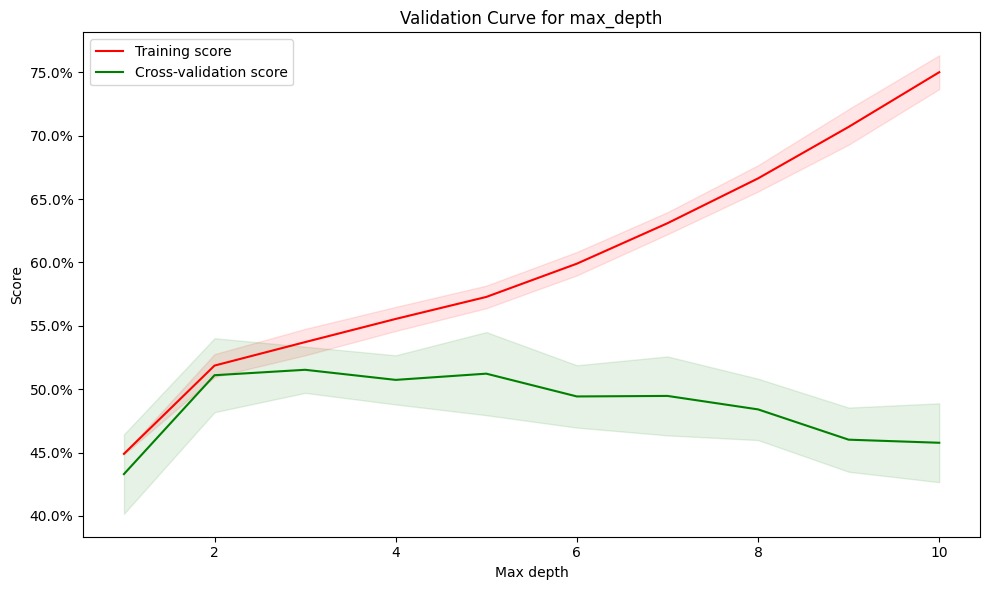

New Parameters Set: {'max_depth': 3}


In [85]:
class DTClassifier(BaseClassifier):
    def __init__(
        self,
        config: Type[Config],
        param_grid: Dict[str, List[int]],
        eval_metric: str,
    ):
        super().__init__(
            model=DecisionTreeClassifier(random_state=config.RANDOM_SEED),
            config=config,
            param_grid=param_grid,
            eval_metric=eval_metric,
            seed=config.RANDOM_SEED,
            verbose=config.VERBOSE,
        )

    def get_model_name(self) -> str:
        return "Decision Tree Classifier"

    def fit(self, X, y, verbose=True):
        if verbose:
            print("Fitting the model...")
        self.model.fit(X, y)
        if verbose:
            print("Model fitting completed.")
        return self

    def predict(self, X):
        return self.model.predict(X)

    def plot_learning_curve(
        self,
        X: np.array,
        y: np.array,
        param_name: str,
        dataset_name: str,
        cv: int = 5,
        save_plot=True,
        show_plot=False,
    ):
        train_sizes, train_scores, test_scores = learning_curve(self.model, X, y, cv=cv)

        train_scores_mean = np.mean(train_scores, axis=1) * 100
        test_scores_mean = np.mean(test_scores, axis=1) * 100

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), dpi=100, sharey=False)
        annotation = param_name.replace("_", " ").capitalize() + " = " + str(self.model.get_params().get(param_name))
        plt.title(f"Learning Curve ({self.get_model_name()}) | {annotation}")
        plt.xlabel("# of Training Observations")
        plt.ylabel("Score")

        plt.plot(
            train_sizes, train_scores_mean, "o-", color="r", label="Training score"
        )
        plt.plot(
            train_sizes,
            test_scores_mean,
            "o-",
            color="g",
            label="Cross-validation score",
        )
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.legend(loc="best")
        plt.tight_layout()

        if save_plot:
            model_name = self.get_model_name().replace(" ", "_")
            plot_name = f"{dataset_name}_{model_name}_learning_curve.png"

            image_path = Path(get_directory(self.config.IMAGE_DIR), plot_name)
            plt.savefig(image_path)
            print(image_path)

        if show_plot:
            plt.show()

    def plot_validation_curve(
        self,
        X,
        y,
        dataset_name,
        param_name,
        param_range,
        cv=5,
        save_plot=True,
        show_plot=False,
    ) -> int:
        """
        Plot a validation curve with the range of hyperparameter values on the X-axis and the metric score on the Y-axis.

        :param estimator: The model/estimator for which the validation curve is plotted.
        :param X: The input data.
        :param y: The target data.
        :param param_name: Name of the hyperparameter to vary.
        :param param_range: The range of values for the hyperparameter.
        :param scoring: The scoring function to use.
        :param cv: The number of cross-validation folds (default is 5).
        :param n_jobs: The number of jobs to run in parallel (default is -1, using all processors).
        :param verbose: The verbosity level (default is 1).

        returns the best hyperparameter value
        """
        # scoring=scoring
        train_scores, test_scores = validation_curve(
            self.model,
            X,
            y,
            param_name=param_name,
            param_range=param_range,
            cv=cv,
            verbose=self.verbose,
        )

        train_scores_mean = np.mean(train_scores, axis=1) * 100
        train_scores_std = np.std(train_scores, axis=1) * 100
        test_scores_mean = np.mean(test_scores, axis=1) * 100
        test_scores_std = np.std(test_scores, axis=1) * 100

        # Get the best parameter value based on the cross-validation score
        best_param_index = np.argmax(test_scores_mean)
        best_param_value = param_range[best_param_index]        

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), dpi=100, sharey=False)
        cleaned_param_name = param_name.replace("_", " ").capitalize()
        plt.title(f"Validation Curve for {param_name}")
        plt.xlabel(cleaned_param_name)
        plt.ylabel("Score")

        plt.plot(param_range, train_scores_mean, label="Training score", color="r")
        plt.fill_between(
            param_range,
            train_scores_mean - train_scores_std,
            train_scores_mean + train_scores_std,
            alpha=0.1,
            color="r",
        )

        plt.plot(
            param_range, test_scores_mean, label="Cross-validation score", color="g"
        )
        plt.fill_between(
            param_range,
            test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std,
            alpha=0.1,
            color="g",
        )

        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.legend(loc="best")
        plt.tight_layout()

        if save_plot:
            model_name = self.get_model_name().replace(" ", "_")
            plot_name = f"{dataset_name}_{model_name}_validation_curve.png"

            image_path = Path(get_directory(self.config.IMAGE_DIR), plot_name)
            plt.savefig(image_path)
            print(image_path)

        if show_plot:
            plt.show()

        return int(best_param_value)

    def plot_training_run_time(self, X, y, cv=5, show_plot=False):
        start_time = time.time()
        scores = cross_val_score(self.model, X, y, cv=cv)
        end_time = time.time()

        runtime = end_time - start_time

        plt.figure()
        plt.title(f"Training Runtime ({self.get_human_readable_model_name()})")
        plt.xlabel("Training examples")
        plt.ylabel("Runtime (seconds)")
        plt.bar(["Run Time"], [runtime])

        if show_plot:
            plt.show()
            
##########################################################################################

parameter_grid = {'max_depth': np.linspace(0, 10, 1)}
eval_metric = 'f1'
seed = 42
wine_dt = DTClassifier(config, parameter_grid, eval_metric)
# wine_dt.unique_hyperparameters
# wine_dt.get_params()
# wine_dt.set_params(ccp_alpha=0.5)
scoring_func = wine_dt.get_scorer('accuracy')

best_param_value = wine_dt.plot_validation_curve(
    X, y, dataset_name = 'winequality-white', param_name = 'max_depth', param_range = np.arange(1,11), save_plot=False, show_plot = True
)
wine_dt.set_params(max_depth=best_param_value)

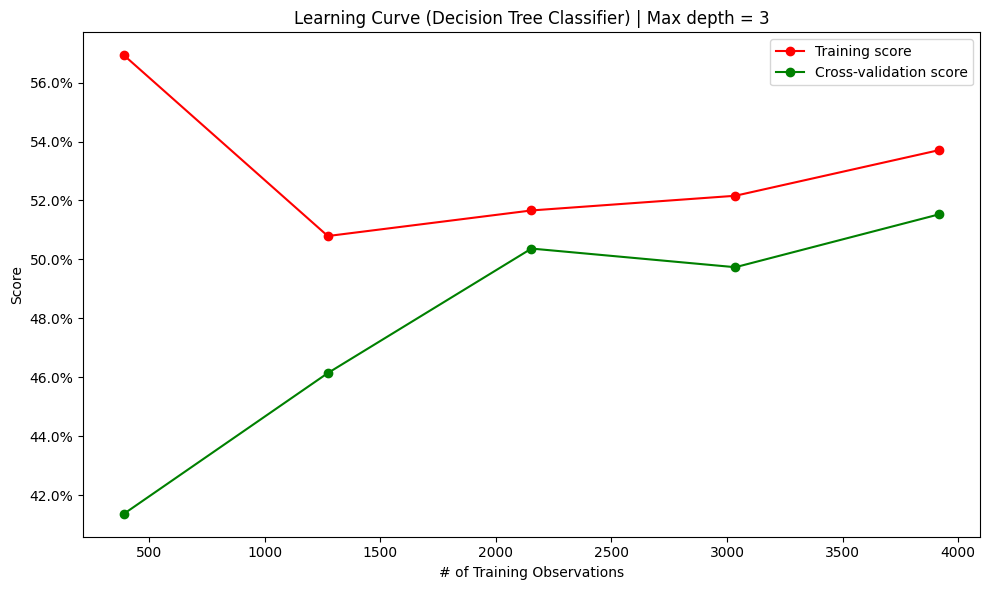

In [86]:
wine_dt.plot_learning_curve(X, y, param_name = "max_depth", dataset_name = 'winequality-white', save_plot=False, show_plot=True)

In [71]:
wine_dt.get_params().get('max_depth')

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [73]:
"max_depth".replace("_", " ").capitalize()

'Max depth'

In [49]:
def build_pipeline(model, numeric_features, categorical_features, scale_features=False, normalize_features=False, scale_target=False, normalize_target=False):
    # Check scaling and normalization flags
    if scale_features and normalize_features:
        raise ValueError("Both scale_features and normalize_features cannot be True at the same time.")
    if scale_target and normalize_target:
        raise ValueError("Both scale_target and normalize_target cannot be True at the same time.")
    
    # Preprocessing for numeric features
    numeric_transformer = []
    if scale_features:
        numeric_transformer.append(('scaler', StandardScaler()))
    elif normalize_features:
        numeric_transformer.append(('scaler', MinMaxScaler()))
        
    numeric_transformer = Pipeline(steps=numeric_transformer)
    
    # Preprocessing for categorical features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Create pipeline
    steps = [('preprocessor', preprocessor), ('model', model)]
    pipeline = Pipeline(steps=steps)
    
    # Optionally scale the target
    if scale_target or normalize_target:
        target_scaler = TargetScaler(method='standard' if scale_target else 'minmax')
        pipeline = Pipeline(steps=[('target_scaler', target_scaler), ('pipeline', pipeline)])
    
    return pipeline